In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

REF_POINTS_CSV = 'FRI/points.csv'

In [2]:
# TODO: temporary
# exact lat and lng
E_lat, E_lng = (46.05014119444443, 14.46859405555556) # Coordinates obtained the evidence E
P1_lat, P1_lng = (46.05071708333332, 14.469447750000002) # Map defined coordinates of the first proposed point where E was actually generated
P2_lat, P2_lng = (46.05091916666666, 14.468425388888889) # Map defined coordinates of the second proposed point where E was actually generated
known_df = pd.DataFrame({
    'name': ['E', 'Exact P1', 'Exact P2'],
    'lat': [E_lat, P1_lat, P2_lat],
    'lng': [E_lng, P1_lng, P2_lng],
})
known_df
# Our goal is to assist the investigation by providing a quantification of whether the the device was at the proposed points P1 and P2 when it took the evidence E due to GPS error.

,name,lat,lng
0,E,46.050141,14.468594
1,Exact P1,46.050717,14.469448
2,Exact P2,46.050919,14.468425


In [3]:
proposal_ref_points_df = pd.read_csv(REF_POINTS_CSV)
# drop rows where precise is off
proposal_ref_points_df = proposal_ref_points_df[proposal_ref_points_df['precise'] == 'on']
# drop rows where point is not P1 or P2
proposal_ref_points_df = proposal_ref_points_df[proposal_ref_points_df['point'].isin(['P1', 'P2'])]
# drop columns we don't need
proposal_ref_points_df = proposal_ref_points_df[['point', 'lat', 'lng']]
proposal_ref_points_df = proposal_ref_points_df.rename(columns={'point': 'ref_point'})
# ref point to category
proposal_ref_points_df['ref_point'] = proposal_ref_points_df['ref_point'].astype('category')
assert set(proposal_ref_points_df['ref_point'].unique().tolist()) == set(['P1', 'P2'])
display(proposal_ref_points_df)
proposal_ref_points_df.describe(include='all')


,ref_point,lat,lng
1,P2,46.050925,14.468442
2,P2,46.050925,14.468439
4,P2,46.050903,14.468411
5,P1,46.050731,14.469450
6,P2,46.050925,14.468444
...,...,...,...
439,P2,46.050925,14.468442
447,P2,46.050908,14.468372
448,P1,46.050700,14.469453
449,P2,46.050925,14.468442


,ref_point,lat,lng
count,200,200.000000,200.000000
unique,2,NaN,NaN
top,P1,NaN,NaN
freq,100,NaN,NaN
mean,NaN,46.050818,14.468937
std,NaN,0.000102,0.000513
min,NaN,46.050700,14.468364
25%,NaN,46.050725,14.468442
50%,NaN,46.050817,14.468944
75%,NaN,46.050925,14.469450


<Axes: xlabel='lng', ylabel='lat'>

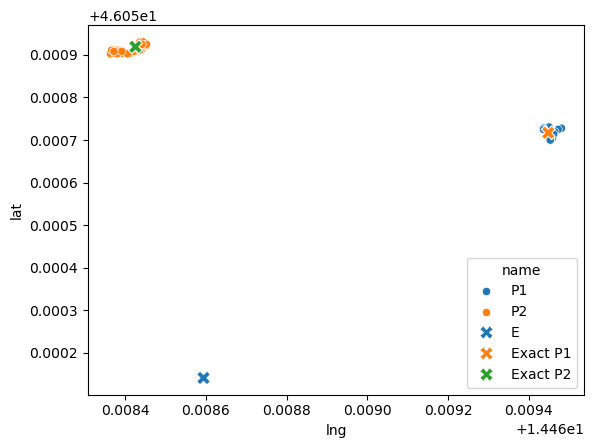

In [4]:
# visualize points
fig, ax = plt.subplots()
sns.scatterplot(data=proposal_ref_points_df, x='lng', y='lat', hue='ref_point')
sns.scatterplot(data=known_df, x='lng', y='lat', hue='name', marker='X', s=100)

In [9]:
from geographiclib.geodesic import Geodesic

import math
def lat_lng2dist_ang(zero_coords, coords):
    # zero_coords = [lat, lng]
    # coords = [lat, lng]
    # computes distance (in meters) between two points and azimuth (angle from north in radians) of the line using WGS84 ellipsoid, line spins around zero_coords
    # computes angle (in radians) between two points
    results = Geodesic.WGS84.Inverse(zero_coords[0], zero_coords[1], coords[0], coords[1])
    distance = results['s12']
    angle_deg = results['azi1']
    angle = math.radians(angle_deg)
    return distance, angle


def prepare_points(exact_proposal_point_lat_lng, proposal_ref_points_df):
    # ref_point = [lat, lng]
    proposal_ref_points_df["dist"] = proposal_ref_points_df.apply(lambda x: lat_lng2dist_ang(exact_proposal_point_lat_lng, [x["lat"], x["lng"]])[0], axis=1)
    proposal_ref_points_df["angle"] = proposal_ref_points_df.apply(lambda x: lat_lng2dist_ang(exact_proposal_point_lat_lng, [x["lat"], x["lng"]])[1], axis=1)
    
    return proposal_ref_points_df


p1_refs = proposal_ref_points_df[proposal_ref_points_df['ref_point'] == 'P1'].copy()
p2_refs = proposal_ref_points_df[proposal_ref_points_df['ref_point'] == 'P2'].copy()
p1_refs = prepare_points([P1_lat, P1_lng], p1_refs)
p2_refs = prepare_points([P2_lat, P2_lng], p2_refs)

display(p1_refs)
display(p2_refs)
# TODO: get rid of *consecutive* duplicate rows


,ref_point,lat,lng,dist,angle
5,P1,46.050731,14.469450,1.507559,0.115765
8,P1,46.050728,14.469481,2.803403,1.132911
11,P1,46.050728,14.469436,1.491446,-0.648451
12,P1,46.050700,14.469453,1.938310,2.939471
20,P1,46.050700,14.469453,1.938310,2.939471
...,...,...,...,...,...
434,P1,46.050700,14.469453,1.938310,2.939471
436,P1,46.050700,14.469453,1.938310,2.939471
437,P1,46.050700,14.469453,1.938310,2.939471
448,P1,46.050700,14.469453,1.938310,2.939471


,ref_point,lat,lng,dist,angle
1,P2,46.050925,14.468442,1.416840,1.095468
2,P2,46.050925,14.468439,1.229636,1.015375
4,P2,46.050903,14.468411,2.130600,-2.596347
6,P2,46.050925,14.468444,1.610993,1.156575
7,P2,46.050925,14.468442,1.416840,1.095468
...,...,...,...,...,...
427,P2,46.050925,14.468453,2.216637,1.273946
428,P2,46.050908,14.468392,2.874235,-2.003081
439,P2,46.050925,14.468442,1.416840,1.095468
447,P2,46.050908,14.468372,4.287263,-1.855493


(np.int64(91), np.int64(72))

In [6]:
E_dist_angle_wrt_P1 = lat_lng2dist_ang((P1_lat, P1_lng), (E_lat, E_lng))
E_dist_angle_wrt_P2 = lat_lng2dist_ang((P2_lat, P2_lng), (E_lat, E_lng))
print(E_dist_angle_wrt_P1)
print(E_dist_angle_wrt_P2)

(91.99285869555308, -2.340365659375521)
(87.45310675146861, 2.9917679628772227)


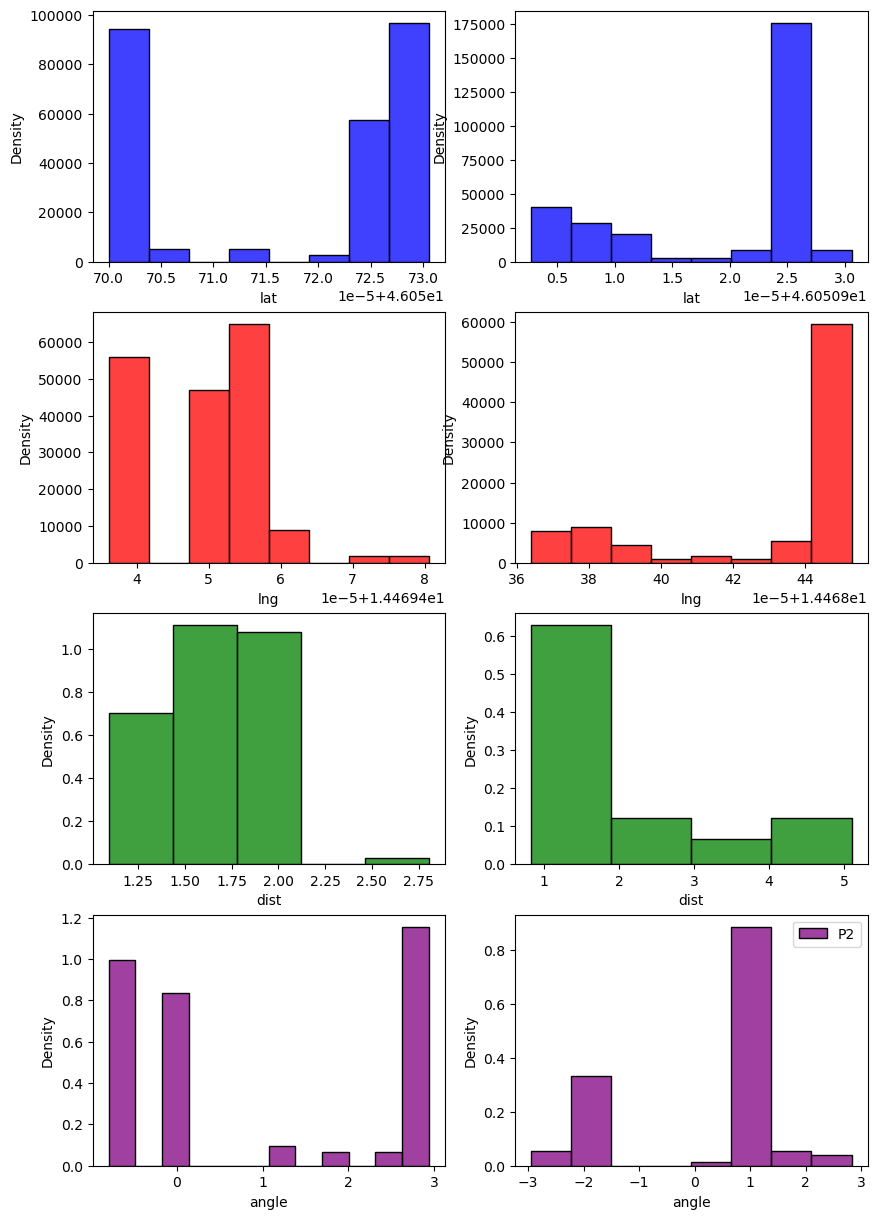

In [7]:
# histograms for dist and ang hue ref_point
# histograms for lat and lng hue ref_point
fig, ax = plt.subplots(4, 2, figsize=(10, 15))

# lat lng dist and angle histograms per column ( 2 columns for each ref_point)
sns.histplot(data=p1_refs, x='lat', bins='auto', color='blue', label='P1', ax=ax[0,0], stat='density')
sns.histplot(data=p1_refs, x='lng', bins='auto', color='red', label='P1', ax=ax[1,0], stat='density')
sns.histplot(data=p1_refs, x='dist', bins=5, color='green', label='P1', ax=ax[2,0], stat='density')
sns.histplot(data=p1_refs, x='angle', bins=12, color='purple', label='P1', ax=ax[3,0], stat='density')

sns.histplot(data=p2_refs, x='lat', bins='auto', color='blue', label='P2', ax=ax[0,1], stat='density')
sns.histplot(data=p2_refs, x='lng', bins='auto', color='red', label='P2', ax=ax[1,1], stat='density')
sns.histplot(data=p2_refs, x='dist', binwidth=1, color='green', label='P2', ax=ax[2,1], stat='density')
sns.histplot(data=p2_refs, x='angle', color='purple', label='P2', ax=ax[3,1], stat='density')


# sns.histplot(data=p1_refs, x='lat', bins='auto', color='blue', label='P1', kde=True, ax=ax[0,0])
# sns.histplot(data=p2_refs, x='lat', bins='auto', color='red', label='P2', kde=True, ax=ax[0,0])
# sns.histplot(data=p1_refs, x='lng', bins='auto', color='blue', label='P1', kde=True, ax=ax[0,1])
# sns.histplot(data=p2_refs, x='lng', bins='auto', color='red', label='P2', kde=True, ax=ax[0,1])
# # evidence vertical line
# ax[0,0].axvline(E_lat, color='black', linestyle='--')
# ax[0,1].axvline(E_lng, color='black', linestyle='--')

# sns.histplot(data=p1_refs, x='dist', bins='auto', color='blue', label='P1', kde=True, ax=ax[1,0])
# sns.histplot(data=p2_refs, x='dist', bins='auto', color='red', label='P2', kde=True, ax=ax[1,0])
# sns.histplot(data=p1_refs, x='angle', bins=12, color='blue', label='P1', kde=True, ax=ax[1,1])
# sns.histplot(data=p2_refs, x='angle', bins=12, color='red', label='P2', kde=True, ax=ax[1,1])

# # evidence vertical line
# # ax[1,0].axvline(E_dist_angle_wrt_P1[0], color='black', linestyle='--')
# # ax[1,1].axvline(E_dist_angle_wrt_P1[1], color='black', linestyle='--')

plt.legend()